<a href="https://colab.research.google.com/github/adamiaonr/cveml/blob/main/projects/scripts/notebooks/ei_image_raw_uploader_adamiaonr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification: Raw Uploader

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/1.3.1%20-%20Using%20Colab%20to%20Curate%20and%20Upload%20a%20Dataset/ei_image_raw_uploader.ipynb)

Run this notebook to convert images to a single row of raw, normalized values (between 0 and 1) and upload them to Edge Impulse as raw samples. Note that pixel values will be normalized to be between 0 and 1.

Create a folder named "dataset" in the /content directory and upload your images there. The images should be divided into their respective classes, where each class has its own folder with the name of the class. For example:

<pre>
/content
    |- dataset
        |- background
        |- capacitor
        |- diode
        |- led
        |- resistor
</pre>

Author: EdgeImpulse, Inc.<br>
Date: June 6, 2021<br>
Modified by: adamiaonr@gmail.com<br>
Last modified: January 2, 2022<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import random, os, PIL, json, time, hmac, hashlib, requests, threading, queue
import pandas as pd

from skimage.transform import resize                      # Used to scale/resize image arrays

In [ ]:
### Settings

# Edge Impulse > your_project > Dashboard > Keys
EI_API_KEY = "ei_1131d579b1c4ed971f17e1fa8e584ecd29d489053d65d12a523b2287c93614fa" 
EI_HMAC_KEY = "126385cbaf09cb76ea4eb7a22bc14836"

# Number of threads to run to upload data to Edge Impulse
NUM_THREADS = 1

# Location of dataset
DATASET_PATH = "/content/dataset"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for test set (Edge Impulse automatically extracts validation set during training)
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)

In [ ]:
# remove folders
!rm -rf "/content/dataset"


In [ ]:
# unzip dataset
!unzip "/content/augmented_dataset.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/content/output/led/014_71.png  
 extracting: /content/dataset/content/output/led/005_3.png  
 extracting: /content/dataset/content/output/led/008_16.png  
 extracting: /content/dataset/content/output/led/030_55.png  
 extracting: /content/dataset/content/output/led/040_92.png  
 extracting: /content/dataset/content/output/led/021_124.png  
 extracting: /content/dataset/content/output/led/027_100.png  
 extracting: /content/dataset/content/output/led/034_10.png  
 extracting: /content/dataset/content/output/led/039_77.png  
 extracting: /content/dataset/content/output/led/033_71.png  
 extracting: /content/dataset/content/output/led/014_20.png  
 extracting: /content/dataset/content/output/led/027_33.png  
 extracting: /content/dataset/content/output/led/012_61.png  
 extracting: /content/dataset/content/output/led/012_71.png  
 extracting: /content/dataset/content/output/led/006_99.png  
 extracting: /cont

In [ ]:
# rename unzipped folders
!mv "/content/dataset/content/output/background" "/content/dataset/"
!mv "/content/dataset/content/output/capacitor" "/content/dataset/"
!mv "/content/dataset/content/output/led" "/content/dataset/"
!mv "/content/dataset/content/output/resistor" "/content/dataset/"

# remove 'content' folder
!rm -rf "/content/dataset/content"


## Curate Image Dataset

The following cells perform the following:
 * Load images from filesystem as grayscale values
 * Set aside some portion of the dataset as test data
 * Resize images
 * Normalize pixel value from [0, 255] to [0.0, 1.0]
 * Flatten images to 1D array

In [ ]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground truth labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
  class_dir = os.path.join(DATASET_PATH, label)
  if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
    labels.append(label)

    # Go through each image in the folder
    for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
      if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
        file_path = os.path.join(class_dir, file)
        img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
        img_array = np.asarray(img)
        if INVERT:
          img_array = 255 - img_array
        X_all.append(img_array)

        # Add label to the y array
        y_all.append(label)

        # Add an extra 'mirrored' example
        # X_all.append(np.flip(img_array, 0))
        # y_all.append(label)

    # Show how many images we loaded
    print("Added", str((i + 1)), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)


Added 6450 images from led
Added 6450 images from background
Added 6450 images from resistor
Added 6450 images from capacitor
['background', 'capacitor', 'led', 'resistor']
Number of samples: 25800


In [ ]:
### Shuffle samples and labels together, divide into test and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The remaining samples become the training set
X_train = X_all[num_samples_test:]
y_train = y_all[num_samples_test:]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test and training samples
print("Number of test samples:", num_samples_test)
print("Number of training samples:", num_samples_train)


Number of test samples: 5160
Number of training samples: 20640


Label: led
[[252 253 253 253 241 198 196 193 190 185 184 180 180 177 177 177 174 172
  171 166 164 158 148 207 255 254 254 254]
 [253 252 246 191 184 177 175 178 175 174 171 170 168 168 167 166 167 168
  167 165 162 159 152 214 255 255 255 255]
 [253 252 189 182 177 178 179 180 177 177 175 173 172 171 171 167 169 172
  170 169 164 176 185 217 255 255 255 254]
 [252 242 188 179 180 181 183 186 188 186 186 186 185 185 184 183 188 203
  202 222 211 254 255 253 255 255 255 255]
 [248 215 188 182 184 186 191 200 201 198 198 205 221 251 253 255 255 255
  255 255 255 254 254 246 255 255 255 255]
 [237 191 189 190 191 194 203 205 209 205 201 200 195 195 200 231 233 231
  214 232 211 208 185 167 155 173 200 199]
 [222 193 193 196 199 204 209 209 208 206 204 201 198 195 188 172 181 180
  179 188 196 188 183 163 152 152 152 149]
 [216 195 199 202 206 212 216 219 215 213 209 206 202 198 191 173 181 181
  179 180 183 176 177 158 170 178 185 190]
 [220 187 201 207 211 218 222 224 223 218 214 210 207

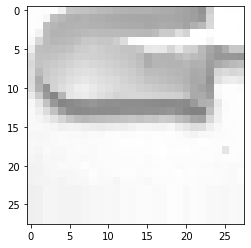

In [ ]:
### View one of the training samples

# Chose which sample you want to view
idx = 16

# Print out label (numbe and string) and part of the array
print("Label: " + y_train[idx])
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)


In [ ]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
  """
  Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
  width. Returns the list of newly resized image arrays.

  NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
  """
  X_out = []
  for i, img in enumerate(images):
    X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
  return X_out


In [ ]:
### Scale/crop images (Note: also normalizes data to 0..1)

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)


Label: resistor
First row: [[0.99215686 0.99215686 0.99215686 0.99215686 0.99215686 0.99215686
  0.99215686 0.99215686 0.99215686 0.99215686 0.99215686 0.99215686
  0.99215686 0.99607843 0.99215686 0.99215686 0.99215686 0.99607843
  0.99215686 0.99215686 0.98823529 0.98823529 0.99215686 0.99215686
  0.99215686 0.99607843 0.99215686 0.99215686]]


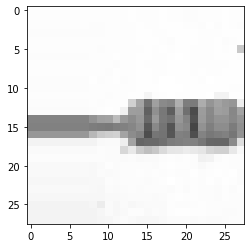

In [ ]:
### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + y_train[idx])
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)


In [ ]:
### Convert list of samples into Numpy arrays

# Convert sets
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Test X:", X_test.shape)


Training X: (20640, 28, 28)
Test X: (5160, 28, 28)


In [ ]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that we will flatten each image to
len_vector = TARGET_WIDTH * TARGET_WIDTH

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Test X:", X_test.shape)


Training X: (20640, 784)
Test X: (5160, 784)


## Helper Functions

The following functions are used to assist in task of uploading samples to your Edge Impulse project.

In [ ]:
def create_json_wrapper():
  """
  Construct initial JSON wrapper as a template
  """

  # Start with all zeros. Hs256 gives 32 bytes and we encode in hex. So, we need 64 characters here.
  empty_signature = ''.join(['0'] * 64)

  # Create JSON wrapper for data
  data = {
      "protected": {
          "ver": "v1",
          "alg": "HS256",
          "iat": time.time()                  # Epoch time, seconds since 1970
      },
      "signature": empty_signature,
      "payload": {
          "device_type": "pre-made",          # Pre-made dataset (not collected)
          "interval_ms": 1,                   # Pretend it's interval of 1 ms
          "sensors": [
              { "name": "img", "units": "B" } # Unitless ("Byte" data)
          ],
          "values": []
      }
  }

  return data

In [ ]:
def send_sample(data, label, test_set=False):
  """
  Send raw data sample to Edge Impulse project, return HTTP status code
  """

  # Encode message in JSON format
  encoded = json.dumps(data)

  # Sign message
  signature = hmac.new(bytes(EI_HMAC_KEY, 'utf-8'), 
                      msg = encoded.encode('utf-8'), 
                      digestmod = hashlib.sha256).hexdigest()

  # Set the signature in the message and encode data again to JSON format
  data['signature'] = signature
  encoded = json.dumps(data)

  # Construct URL based on dataset being sent
  if test_set:
    url = 'https://ingestion.edgeimpulse.com/api/testing/data'
  else:
    url = 'https://ingestion.edgeimpulse.com/api/training/data'

  # Upload the data to project
  res = requests.post(url=url,
                      data=encoded,
                      headers={
                          'Content-Type': 'application/json',
                          'x-file-name': str(label),
                          'x-api-key': EI_API_KEY
                      })
  
  return res

In [ ]:
def upload_sample(len_vector, is_test_set):
  """
  Pull sample and label from queue and send to Edge Impulse server. To be called within a thread.
  """

  global q

  while not q.empty():

    # Start with empty JSON wrapper
    data = create_json_wrapper()

    # Fill up values field (we need to convert to float to avoid JSON error)
    sample, label = q.get()
    for j in range(len_vector):
      data['payload']['values'].append(float(sample[j]))

    # Send sample
    res = send_sample(data, label, test_set=is_test_set)

    # Check response code
    if (res.status_code != 200):
      print("Failed to upload file to Edge Impulse", res.status_code, res.content)

In [ ]:
# save data in array argument in .csv format for upload to edge impulse
def to_csv(x_data, y_data, dst_folder, offset = 0):
  for i in range(x_data.shape[0]):
    img_data = pd.DataFrame(data = np.arange(x_data[i].shape[0]), columns = ['timestamp'])
    img_data['img'] = x_data[i]
    img_data.to_csv(os.path.join(dst_folder, "%s/%s-%05d.csv" % (y_data[i], y_data[i], i + offset)), index = False)


## Save dataset in .csv format

In [ ]:
# save training and test data in .csv format
csv_folder = "/content/csv"

# remove any previous instance of folder
!rm -rf "/content/csv"

# create csv dir and folders for each label
os.makedirs(csv_folder, exist_ok = True)
for label in labels:
  os.makedirs(os.path.join(csv_folder, label), exist_ok = True)


In [ ]:
to_csv(X_train, y_train, dst_folder = csv_folder)
to_csv(X_test, y_test, dst_folder = csv_folder, offset = X_train.shape[0])


In [ ]:
# save dataset in .csv format in .zip file
out_zip = "augmented_dataset_csv.zip"
!zip -r -q "{out_zip}" "{csv_folder}"


## Upload training and test sets to Edge Impulse

In [ ]:
### Use many threads to send training data and labels to Edge Impulse project

# Fill queue with training data and labels
q = queue.Queue()
for i in range(num_samples_train):
  q.put((X_train[i], y_train[i]))

# Create and start threads
threads = []
for i in range(NUM_THREADS):
  threads.append(threading.Thread(target=upload_sample, args=(len_vector, False)))
  threads[i].start()

# Wait for threads to be done
for thread in threads:
  thread.join()

KeyboardInterrupt: ignored

In [ ]:
### Use many threads to send test data and labels to Edge Impulse project

# Fill queue with test data and labels
q = queue.Queue()
for i in range(num_samples_test):
  q.put((X_test[i], y_test[i]))

# Create and start threads
threads = []
for i in range(NUM_THREADS):
  threads.append(threading.Thread(target=upload_sample, args=(len_vector, True)))
  threads[i].start()

# Wait for threads to be done
for thread in threads:
  thread.join()